## Introduction

This is a sand pit for experimenting with the ideas around using sentiment analysis to understand plot trajectories. My work on this was prompted by the discussion surrounding [Matthew L. Jockers](http://www.matthewjockers.net/) [Syuzhet Package](http://www.matthewjockers.net/2015/02/02/syuzhet/).

I don't use R, so I'm attempting to reproduce and extend Matthew's findings via this iPython Notebook.

## The meaning of noise

Discomfort around use of notion of 'noise'. Assuming the whole sentiment analysis tactic makes sense, there are two sources:

* Algorithmic Noise - arising because the sentiment analysis makes mistakes.
* Narrative Noise - arising from the prose itself.

Niether of these is likely to be simple Gaussian noise. Preference to defer interpreted of the noise and find different ways to look at the data.


## Related publications

* [Revealing Sentiment and Plot Arcs with the Syuzhet Package](http://www.matthewjockers.net/2015/02/02/syuzhet/)
    * Building on [A Novel Method for Detecting Plot](http://www.matthewjockers.net/2014/06/05/a-novel-method-for-detecting-plot/)
    * [Detailed outline of process](https://github.com/mjockers/syuzhet/blob/3a12441b1ebb01802f9d24d0fc4be1ab2b64e883/inst/doc/syuzhet-vignette.Rmd)
    * [Core R source code](https://github.com/mjockers/syuzhet/blob/master/R/syuzhet.R)
* Twitter discussion, "Fabula of Syuzhet", collected by [Eileen Clancy](https://twitter.com/clancynewyork):
    * [A Fabula of Syuzhet](https://storify.com/clancynewyork/contretemps-a-syuzhet)
    * [A Fabula of Syuzhet II](https://storify.com/clancynewyork/a-fabula-of-syuzhet-ii/)
* [Problems with the Syuzhet Package](https://annieswafford.wordpress.com/2015/03/02/syuzhet/)
* [Why it’s hard for syuzhet to be right or wrong yet](http://tedunderwood.com/2015/03/24/why-its-hard-for-syuzhet-to-be-right-or-wrong-yet/)
* [What’s a Sine Wave of Sentiment?](http://www.lagado.name/blog/?p=78)
* [Commodius vici of recirculation: the real problem with Syuzhet](http://benschmidt.org/2015/04/03/commodius-vici-of-recirculation-the-real-problem-with-syuzhet/)
* [Requiem for a low pass filter](http://www.matthewjockers.net/2015/04/06/epilogue/)
* [A Sentimental Derivative](http://www.lagado.name/blog/?p=137)




## Dependencies

I installed TextBlob for [NLTK](http://www.nltk.org/)-powered analysis:

```
$ pip3 install -U textblob
$ python3 -m textblob.download_corpora
```

I downloaded the AFINN implementation from [here](https://finnaarupnielsen.wordpress.com/2011/06/20/simplest-sentiment-analysis-in-python-with-af/) and patched it to work with Python3 ([here](./afinn.py)).

I downloaded some books, e.g. (http://www.gutenberg.org/ebooks/4217)

I could not find implementations of the 'bing' and 'nrc' sentiment algorithms, and have not yet tried plumbing in the Stanford parser. I'm using AFINN as the default to try to make results comparible across implementations.

I do not have access to all of the texts used by Matthew, which also limits reproducibility.

## Implementation

The following code sets up basic sentence-level sentiment analysis. The main addition is that it also supports collecting the 'culmulative emotional valence' as well as just the 'local' values.


In [33]:
from textblob import TextBlob
import afinn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5

def senticuml(filename, method='afinn', show_sample=False):
    with open (filename, "r") as myfile:
        text=myfile.read().replace('\n', ' ')   

        blob = TextBlob(text)       

        tot = 0.0
        sent = []
        cuml = []
        i = 0
        for sentence in blob.sentences:
            if method == 'afinn':
                senti = afinn.sentiment(str(sentence))
            else:
                senti = sentence.sentiment.polarity
            sent.append(senti)
            tot = tot + senti
            cuml.append(tot)
            i += 1
            if i > 100 and i < 110 and show_sample:
                print(tot, senti, sentence[0:40])
                
        return sent, cuml

def sentiplot(filename, title, use_cuml=True, method='afinn'):
    fig = plt.figure()
    sent, cuml = senticuml(filename, method=method)
    if use_cuml == True:
        plt.plot(cuml,label=title)
    else:
        plt.plot(sent,label=title)
    plt.legend()
    

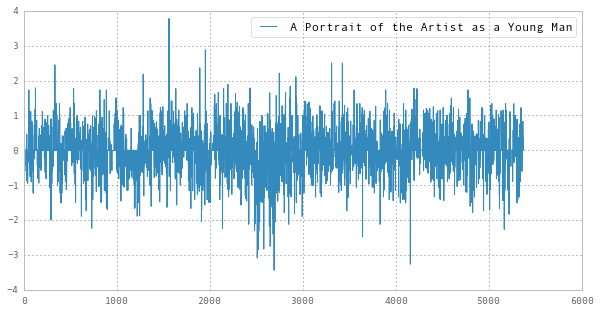

In [34]:
sentiplot("texts/pg4217-trimmed.txt", "A Portrait of the Artist as a Young Man",use_cuml=False)

This seems broadly comparable with the 'noisy plot' shown [here](http://www.matthewjockers.net/2015/02/02/syuzhet/)

<img width="500" src="http://www.matthewjockers.net/wp-content/uploads/2015/02/noisy.png">

However, Matthew is using the 'bing' method (which seems to be a more heavily discretised scale than AFINN), so the results are not directly comparable.

### Cumulative Emotional Valence

Rather than immediately attempting to 'smooth out' this noisy data, I'd like to find alternative ways of interpreting and visualising the data to make the structure clearer. Here, we treat the sentence-level 'emotional valance' as a modulation, rather than presenting it as an absolute. Specifically, we shift to presenting the sum of the individual values of the emotional valence as we 'read' through the text, what I'll call the 'cumulative emotional valence'.

Taking this approach, the noisy parts are naturally diminished, and the runs of positive or negative sentiment are much clearer:

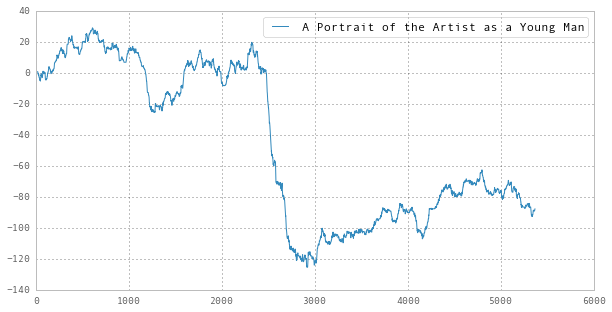

In [35]:
sentiplot("texts/pg4217-trimmed.txt", "A Portrait of the Artist as a Young Man")

Here is the same plot for the Da Vinci Code. Comparing this (rather arbitrarily) to *Portrait*, the middle-swing goes up rather than down, and there is a much higher level of fluctuation throughout:

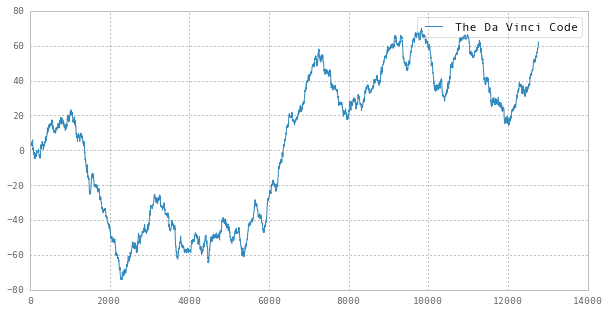

In [36]:
sentiplot("texts/tdvc.txt", "The Da Vinci Code")

And here are the same plots for two more texts that were used as examples during the discussions around the Syuzhet package...

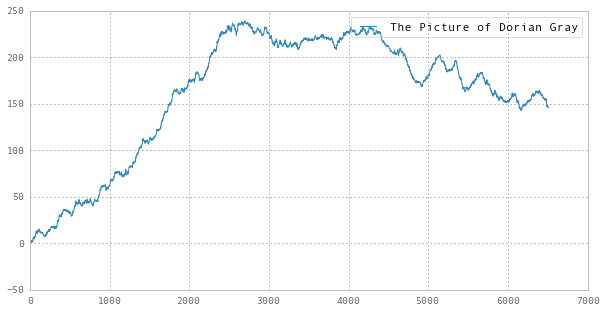

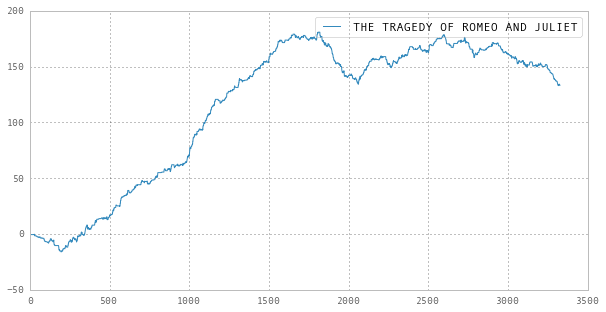

In [37]:
sentiplot("texts/pg174-trimmed.txt", "The Picture of Dorian Gray")
sentiplot("texts/pg1112-trimmed.txt", "THE TRAGEDY OF ROMEO AND JULIET")

Given how these stories end, this probably indicates that this cumulative method rather underestimates the negative swing towards the end of text. (We could perhaps consider a summation window rather than always summing from the start?)

Putting that aside for the moment, what does leap out here is (a) how different these two are from the Joyce example above and (b) how strikingly similar they are to each other. We can investigate this a little further by rescaling and overlaying the two plots...

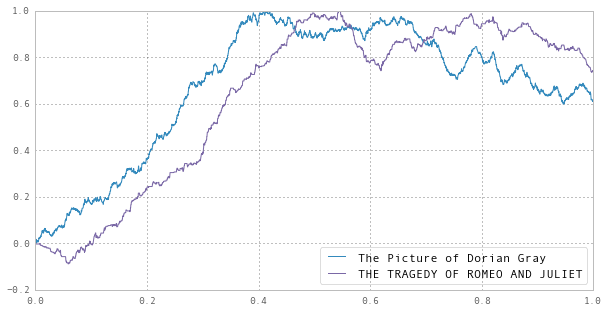

In [38]:
def rescale(cuml):
    max_cuml = max(cuml)
    x = []
    y = []
    for i in range(0,len(cuml)):
        x.append(i/len(cuml))
        y.append(cuml[i]/max_cuml)
    return x,y

sent_pdg, cuml_pdg = senticulm("texts/pg174-trimmed.txt")
sent_trj, cuml_trj = senticulm("texts/pg1112-trimmed.txt")

x_pdg, y_pdg = rescale(cuml_pdg)
x_trj, y_trj = rescale(cuml_trj)
plt.plot(x_pdg, y_pdg, label="The Picture of Dorian Gray")
plt.plot(x_trj, y_trj, label="THE TRAGEDY OF ROMEO AND JULIET")
plt.legend(loc=4)
plt.show()


This is interesting, but hardly conclusive of anything on it's own. It would at least need to be run on a larger corpus and/or compared against randomly generated texts or manually calibrated data sets.

However, as a neat visualisation method for exploring texts, it seems quite appealing and may be worth considering applying to texts found in the web archive. Clearly, this would be much improved by being able to quickly which sections of the text corresponded to which parts of the graph (e.g. hover text, or text-by-plot with highlighting), but that's rather too fancy do to in an iPython Notebook I think.



## On Comparing Sentiment Algorithms

It would be good to produce a more detailed comparison of sentiment analysis algorithms. However, the only other one I have access to right now is the NLTK method wrapped by the Python ```pattern``` package.

Oddly, this seems to consistently lean towards generating positive sentiments in the texts I've tested it on. For example:

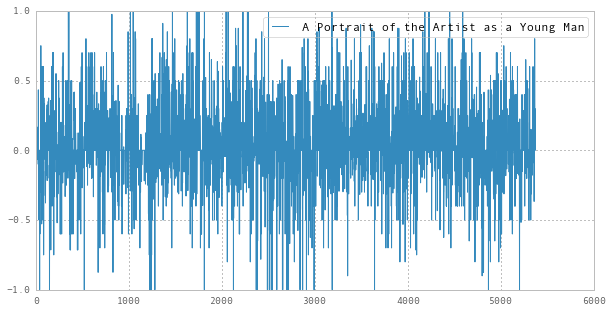

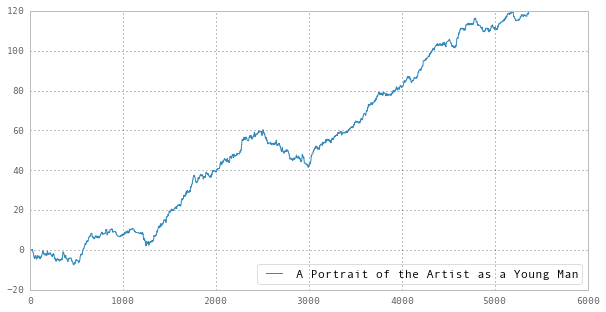

In [45]:
sentiplot("texts/pg4217-trimmed.txt", "A Portrait of the Artist as a Young Man",method="nltk",use_cuml=False)
sentiplot("texts/pg4217-trimmed.txt", "A Portrait of the Artist as a Young Man",method="nltk")
plt.legend(loc=4)
plt.show()

Overlaying multiple plots, the linear trend seems consistent and acts to mask differences between texts...

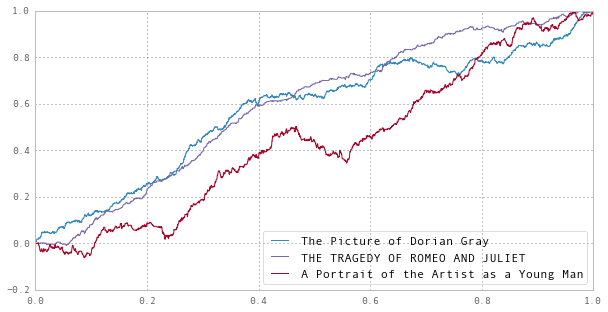

In [44]:
sent_pdg, cuml_pdg = senticulm("texts/pg174-trimmed.txt",method="nltk")
sent_trj, cuml_trj = senticulm("texts/pg1112-trimmed.txt",method="nltk")
sent_pay, cuml_pay = senticulm("texts/pg4217-trimmed.txt",method="nltk")

x_pdg, y_pdg = rescale(cuml_pdg)
x_trj, y_trj = rescale(cuml_trj)
x_pay, y_pay= rescale(cuml_pay)
plt.plot(x_pdg, y_pdg, label="The Picture of Dorian Gray")
plt.plot(x_trj, y_trj, label="THE TRAGEDY OF ROMEO AND JULIET")
plt.plot(x_pay, y_pay, label="A Portrait of the Artist as a Young Man")
plt.legend(loc=4)
plt.show()

## On Smoothing

...

### Suitability of Fourier Transforms

* Pretty sure the periodic thing can be avoided, as I don't think use of wave-based transforms in JPEG or MP3 forces periodicity on the data. Probably ways of dealing with this, like windowing or signal mirroring.
* Pretty sure this is entirely separate from 'ringing artefacts' which are largely arbitrary and arise from how the frequency truncation was done. i.e. a step-function in frequency space creates a ringing sinc in the time axis of the signal, primarily determined by the depth of the step (i.e. the shape+height of frequency curve at truncation point).
* Empirical approach to this is to fiddle with the input parameters and attempt to descern whether fiddling with the frequency cut-off has a stronger effect on the result than twiddling the input data.

Could try fourier smoothing with mirroring to avoid the periodicity problem, but I'm not sure that's worth pursuing yet.

Below from http://stackoverflow.com/questions/19122157/fft-bandpass-filter-in-python

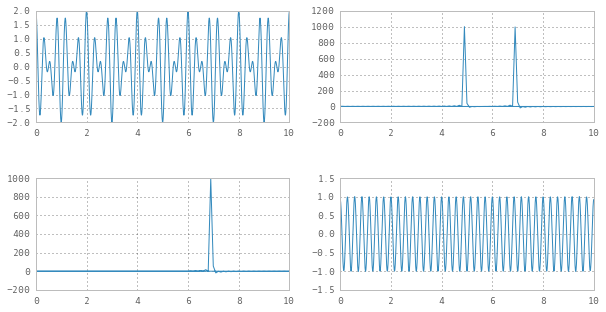

In [40]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq

time   = np.linspace(0,10,2000)
signal = np.cos(5*np.pi*time) + np.cos(7*np.pi*time)

W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W<6)] = 0

cut_signal = irfft(cut_f_signal)

# And plot...

import pylab as plt
plt.subplot(221)
plt.plot(time,signal)
plt.subplot(222)
plt.plot(W,f_signal)
plt.xlim(0,10)
plt.subplot(223)
plt.plot(W,cut_f_signal)
plt.xlim(0,10)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.show()